# **Aspect-based Term Extraction using BERTs**

## **Prepare Dataset**

In [ ]:
!git clone https://huggingface.co/datasets/thainq107/abte-restaurants

In [ ]:
import pandas as pd

# Load datasets
train_df = pd.read_parquet("abte-restaurants/data/train-00000-of-00001.parquet")
test_df = pd.read_parquet("abte-restaurants/data/test-00000-of-00001.parquet")

# Save train and test in JSON Lines format (needed for Hugging Face)
train_df.to_json("train.json", orient="records", lines=True)
test_df.to_json("test.json", orient="records", lines=True)

print("Train and test datasets saved as JSONL!")


In [ ]:
!pip install -q datasets==3.2.0

In [ ]:
from datasets import load_dataset

# Load the dataset from JSON files
ds = load_dataset("json", data_files={"train": "train.json", "test": "test.json"})

# Print dataset structure
print(ds)

In [ ]:
ds.push_to_hub("Chow05/abte_restaurants", token=" ")

## **Load Dataset**

In [ ]:
from datasets import load_dataset

ds = load_dataset("Chow05/SemEval-2014-Task-4")

In [3]:
ds

DatasetDict({
    train: Dataset({
        features: ['Tokens', 'Tags', 'Polarities'],
        num_rows: 3602
    })
    test: Dataset({
        features: ['Tokens', 'Tags', 'Polarities'],
        num_rows: 1119
    })
})

In [4]:
ds['train'][0]

{'Tokens': ['But', 'the', 'staff', 'was', 'so', 'horrible', 'to', 'us', '.'],
 'Tags': ['0', '0', '1', '0', '0', '0', '0', '0', '0'],
 'Polarities': ['-1', '-1', '0', '-1', '-1', '-1', '-1', '-1', '-1']}

## **Build Vocab**

In [ ]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("distilbert/distilbert-base-uncased")

In [6]:
def tokenize_and_align_labels(examples):
    tokenized_inputs = []
    labels = []
    for tokens, tags in zip(examples['Tokens'], examples['Tags']):

        bert_tokens = []
        bert_tags = []
        for i in range(len(tokens)):
            t = tokenizer.tokenize(tokens[i])
            bert_tokens += t
            bert_tags += [int(tags[i])]*len(t)

        bert_ids = tokenizer.convert_tokens_to_ids(bert_tokens)

        tokenized_inputs.append(bert_ids)
        labels.append(bert_tags)

    return {
            'input_ids': tokenized_inputs,
            'labels': labels
        }

In [38]:
preprocessed_ds = ds.map(tokenize_and_align_labels, batched=True)
preprocessed_ds

DatasetDict({
    train: Dataset({
        features: ['Tokens', 'Tags', 'Polarities', 'input_ids', 'labels'],
        num_rows: 3602
    })
    test: Dataset({
        features: ['Tokens', 'Tags', 'Polarities', 'input_ids', 'labels'],
        num_rows: 1119
    })
})

In [36]:
preprocessed_ds['train'][0]

{'Tokens': ['But', 'the', 'staff', 'was', 'so', 'horrible', 'to', 'us', '.'],
 'Tags': ['0', '0', '1', '0', '0', '0', '0', '0', '0'],
 'Polarities': ['-1', '-1', '0', '-1', '-1', '-1', '-1', '-1', '-1'],
 'input_ids': [2021, 1996, 3095, 2001, 2061, 9202, 2000, 2149, 1012],
 'labels': [0, 0, 1, 0, 0, 0, 0, 0, 0]}

In [16]:
len(tokenizer)

30522

## **Evaluate**

In [17]:
!pip install -q seqeval==1.2.2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 2.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [ ]:
id2label = {
    0: "O",
    1: "B-Term",
    2: "I-Term"
}

label2id = {
    "O": 0,
    "B-Term": 1,
    "I-Term": 2
}

In [20]:
import numpy as np
from seqeval.metrics import f1_score

def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)
    true_predictions = [
        [id2label[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    true_labels = [
        [id2label[l] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    results = f1_score(true_predictions, true_labels)
    return {"F1-score": results}

## **Model**

In [ ]:
from transformers import AutoModelForTokenClassification

model = AutoModelForTokenClassification.from_pretrained(
    "distilbert/distilbert-base-uncased",
    num_labels=3, id2label=id2label, label2id=label2id
)

In [4]:
model

DistilBertForTokenClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
    

In [ ]:
import torch
from torchinfo import summary

# Define dummy input
dummy_input = {
    "input_ids": torch.randint(0, 100, (64, 100)),  # Batch size 1, sequence length 128
    "attention_mask": torch.ones(64, 100)  # All tokens are attended
}

summary(
    model, 
    input_data=dummy_input, 
    col_names=["input_size", "output_size", "num_params"]
)

Layer (type:depth-idx)                                  Input Shape               Output Shape              Param #
DistilBertForTokenClassification                        --                        [64, 100, 3]              --
├─DistilBertModel: 1-1                                  [64, 100]                 [64, 100, 768]            --
│    └─Embeddings: 2-1                                  [64, 100]                 [64, 100, 768]            --
│    │    └─Embedding: 3-1                              [64, 100]                 [64, 100, 768]            23,440,896
│    │    └─Embedding: 3-2                              [1, 100]                  [1, 100, 768]             393,216
│    │    └─LayerNorm: 3-3                              [64, 100, 768]            [64, 100, 768]            1,536
│    │    └─Dropout: 3-4                                [64, 100, 768]            [64, 100, 768]            --
│    └─Transformer: 2-2                                 --                        [64, 100,

## **Training**

In [23]:
# Disable wandb
import os
os.environ['WANDB_DISABLED'] = 'true'

# # Use wandb
# import wandb
# wandb.init(
#     project="aspect-based-term-extraction",
#     name="distilbert-base-uncased"
# )

In [ ]:
from transformers import DataCollatorForTokenClassification

data_collator = DataCollatorForTokenClassification(tokenizer=tokenizer)

In [ ]:
from transformers import Trainer, TrainingArguments

training_args = TrainingArguments(
    output_dir="ATE-distilbert-base-uncased-For-SemEval-2014-Task-4",
    logging_dir="logs",
    learning_rate=2e-5,
    per_device_train_batch_size=256,
    per_device_eval_batch_size=256,
    num_train_epochs=55,
    weight_decay=0.01,
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="F1-score",
    # report_to="wandb",
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=preprocessed_ds["train"],
    eval_dataset=preprocessed_ds["test"],
    processing_class=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [26]:
trainer.train()

Epoch,Training Loss,Validation Loss,F1-score
1,0.654900,0.541269,0.002967
2,0.373900,0.306351,0.531176
3,0.232500,0.259566,0.630751
4,0.176100,0.236475,0.686589
5,0.144300,0.217267,0.744291
6,0.105100,0.207947,0.785404
7,0.080700,0.204071,0.811727
8,0.065100,0.208584,0.819776
9,0.050600,0.218336,0.820044
10,0.041300,0.224328,0.819917


TrainOutput(global_step=825, training_loss=0.04325473332946951, metrics={'train_runtime': 1648.4969, 'train_samples_per_second': 120.176, 'train_steps_per_second': 0.5, 'total_flos': 4501224604837800.0, 'train_loss': 0.04325473332946951, 'epoch': 55.0})

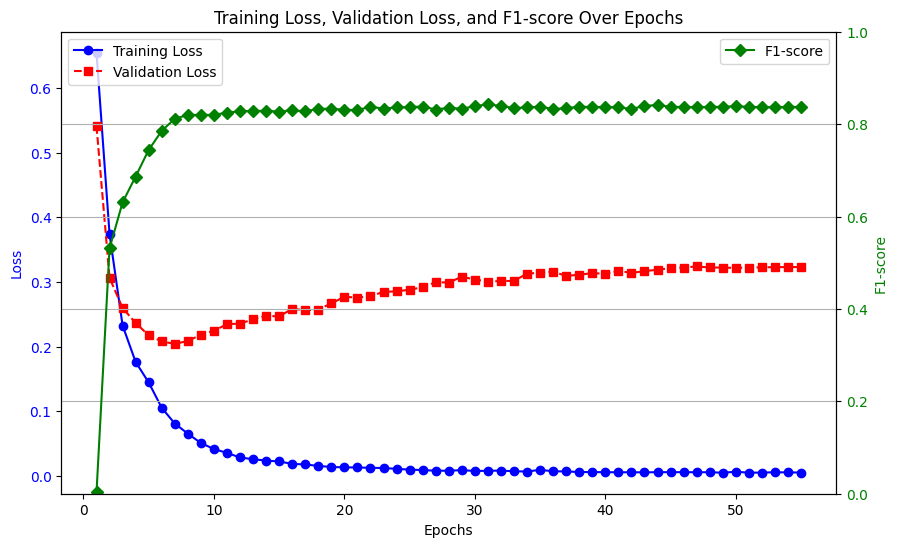

In [64]:
import matplotlib.pyplot as plt

log_history = trainer.state.log_history
epochs = []
train_loss = []
val_loss = []
f1_scores = []

for log in log_history:
    if "epoch" in log:
        epochs.append(log["epoch"])
        train_loss.append(log.get("loss", None))  # Training loss (may be missing)
        val_loss.append(log.get("eval_loss", None))  # Validation loss
        f1_scores.append(log.get("eval_F1-score", None))  # F1-score

# Remove None values (only keep epochs where training loss exists)
train_epochs = [epochs[i] for i in range(len(epochs)) if train_loss[i] is not None]
train_loss = [x for x in train_loss if x is not None]

val_epochs = [epochs[i] for i in range(len(epochs)) if val_loss[i] is not None]
val_loss = [x for x in val_loss if x is not None]

f1_epochs = [epochs[i] for i in range(len(epochs)) if f1_scores[i] is not None]
f1_scores = [x for x in f1_scores if x is not None]

fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot training and validation loss
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Loss", color="blue")
ax1.plot(train_epochs, train_loss, label="Training Loss", marker='o', linestyle='-', color='blue')
ax1.plot(val_epochs, val_loss, label="Validation Loss", marker='s', linestyle='--', color='red')
ax1.tick_params(axis="y", labelcolor="blue")

# Second y-axis for F1-score
ax2 = ax1.twinx()
ax2.set_ylabel("F1-score", color="green")
ax2.plot(f1_epochs, f1_scores, label="F1-score", marker='D', linestyle='-', color='green')
ax2.set_ylim(0, 1)
ax2.tick_params(axis="y", labelcolor="green")

# Legends
ax1.legend(loc="upper left")
ax2.legend(loc="upper right")

plt.title("Training Loss, Validation Loss, and F1-score Over Epochs")
plt.grid(True)
plt.show()


In [ ]:
trainer.save_model("/content/ATE-distilbert-base-uncased-For-SemEval-2014-Task-4")
tokenizer.save_pretrained("/content/ATE-distilbert-base-uncased-For-SemEval-2014-Task-4")
best_model_path = "/content/ATE-distilbert-base-uncased-For-SemEval-2014-Task-4"

model = AutoModelForTokenClassification.from_pretrained(best_model_path)
tokenizer = AutoTokenizer.from_pretrained(best_model_path)


In [ ]:
model.push_to_hub("Chow05/ATE-distilbert-base-uncased-For-SemEval-2014-Task-4", token=" ")
tokenizer.push_to_hub("Chow05/ATE-distilbert-base-uncased-For-SemEval-2014-Task-4", token=" ")


## **Inference**

In [ ]:
from transformers import pipeline

token_classifier = pipeline(
    model="Chow05/ATE-distilbert-base-uncased-For-SemEval-2014-Task-4",
    aggregation_strategy="simple"
)

In [25]:
test_sentence = 'The bread is top notch as well'

results = token_classifier(test_sentence)
results

[{'entity_group': 'Term',
  'score': 0.949988,
  'word': 'bread',
  'start': 4,
  'end': 9}]

In [ ]:
test_sentence = 'Our agreed favorite is the orrecchiete with sausage and chicken'

results = token_classifier(test_sentence)
results

[{'entity_group': 'Term',
  'score': 0.9573238,
  'word': 'orr',
  'start': 27,
  'end': 30},
 {'entity_group': 'Term',
  'score': 0.96824205,
  'word': '##ec',
  'start': 30,
  'end': 32},
 {'entity_group': 'Term',
  'score': 0.89731264,
  'word': '##chi',
  'start': 32,
  'end': 35},
 {'entity_group': 'Term',
  'score': 0.9646067,
  'word': '##ete with',
  'start': 35,
  'end': 43},
 {'entity_group': 'Term',
  'score': 0.9335451,
  'word': 'sausage and',
  'start': 44,
  'end': 55},
 {'entity_group': 'Term',
  'score': 0.8864768,
  'word': 'chicken',
  'start': 56,
  'end': 63}]

In [ ]:
test_sentence = '''
The dish was bursting with flavor, 
perfectly cooked, and left me craving more.
'''

results = token_classifier(test_sentence)
results

[{'entity_group': 'Term',
  'score': 0.9278987,
  'word': 'dish',
  'start': 5,
  'end': 9},
 {'entity_group': 'Term',
  'score': 0.93798155,
  'word': 'flavor',
  'start': 28,
  'end': 34},
 {'entity_group': 'Term',
  'score': 0.92697936,
  'word': 'cooked',
  'start': 47,
  'end': 53}]

In [27]:
test_sentence = '''
The food was absolutely delicious, 
with rich flavors and fresh ingredients that made every bite enjoyable. 
The presentation was stunning, 
and the balance of textures and spices elevated the entire dining experience.
'''
results = token_classifier(test_sentence)
results

[{'entity_group': 'Term',
  'score': 0.995684,
  'word': 'food',
  'start': 5,
  'end': 9},
 {'entity_group': 'Term',
  'score': 0.9867762,
  'word': 'flavors',
  'start': 47,
  'end': 54},
 {'entity_group': 'Term',
  'score': 0.98623985,
  'word': 'ingredients',
  'start': 65,
  'end': 76},
 {'entity_group': 'Term',
  'score': 0.9931685,
  'word': 'presentation',
  'start': 114,
  'end': 126},
 {'entity_group': 'Term',
  'score': 0.9356959,
  'word': 'balance',
  'start': 150,
  'end': 157},
 {'entity_group': 'Term',
  'score': 0.98980534,
  'word': 'textures',
  'start': 161,
  'end': 169},
 {'entity_group': 'Term',
  'score': 0.9898537,
  'word': 'spices',
  'start': 174,
  'end': 180},
 {'entity_group': 'Term',
  'score': 0.9129318,
  'word': 'dining',
  'start': 201,
  'end': 207}]

In [ ]:
test_sentence = 'Elon Musk is the richest person in the world'

results = token_classifier(test_sentence)
results

[{'entity_group': 'Term',
  'score': 0.47959843,
  'word': '##sk',
  'start': 7,
  'end': 9}]